# Statistics on SVM

We will arange data and train SVC on the data.
Then we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic SVM

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.ERROR)
stocks = [TrainingData(sn).add_history(10).set_threshold(0.8).get() for sn in stock_names]

In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2815
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15381882770870337
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [3]:
def run_model(model, stocks=stocks):
    scores = {sn: [] for sn in stock_names}
    for sn, (data, classes) in zip(stock_names, stocks):
        scores[sn] = (sum(cross_val_score(model, data, classes))/3) 
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

In [4]:
from sklearn.svm import SVC
import traceback

# create iterables for all options and use itertools product
C=[0.1, 0.3, 0.5, 0.7, 1.0]
kernel=['linear', 'poly', 'rbf', 'sigmoid']
max_iter=[1200]

svm_models = [SVC(C=c, kernel=k, max_iter=mi) 
          for c, k, mi in product(C, kernel, max_iter)]

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    saccuracies = list(map(run_model, svm_models))

In [ ]:
import pickle

pickle.dump(saccuraciesuraciesuraciescuracies, open('SVM.p', 'wb'))

In [7]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(svm_models, saccuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.kernel, model.max_iter, sn, acc))

sresults = DataFrame(data, columns=('C', 'kernel', 'max_iter', 'stock', 'accuracy'))

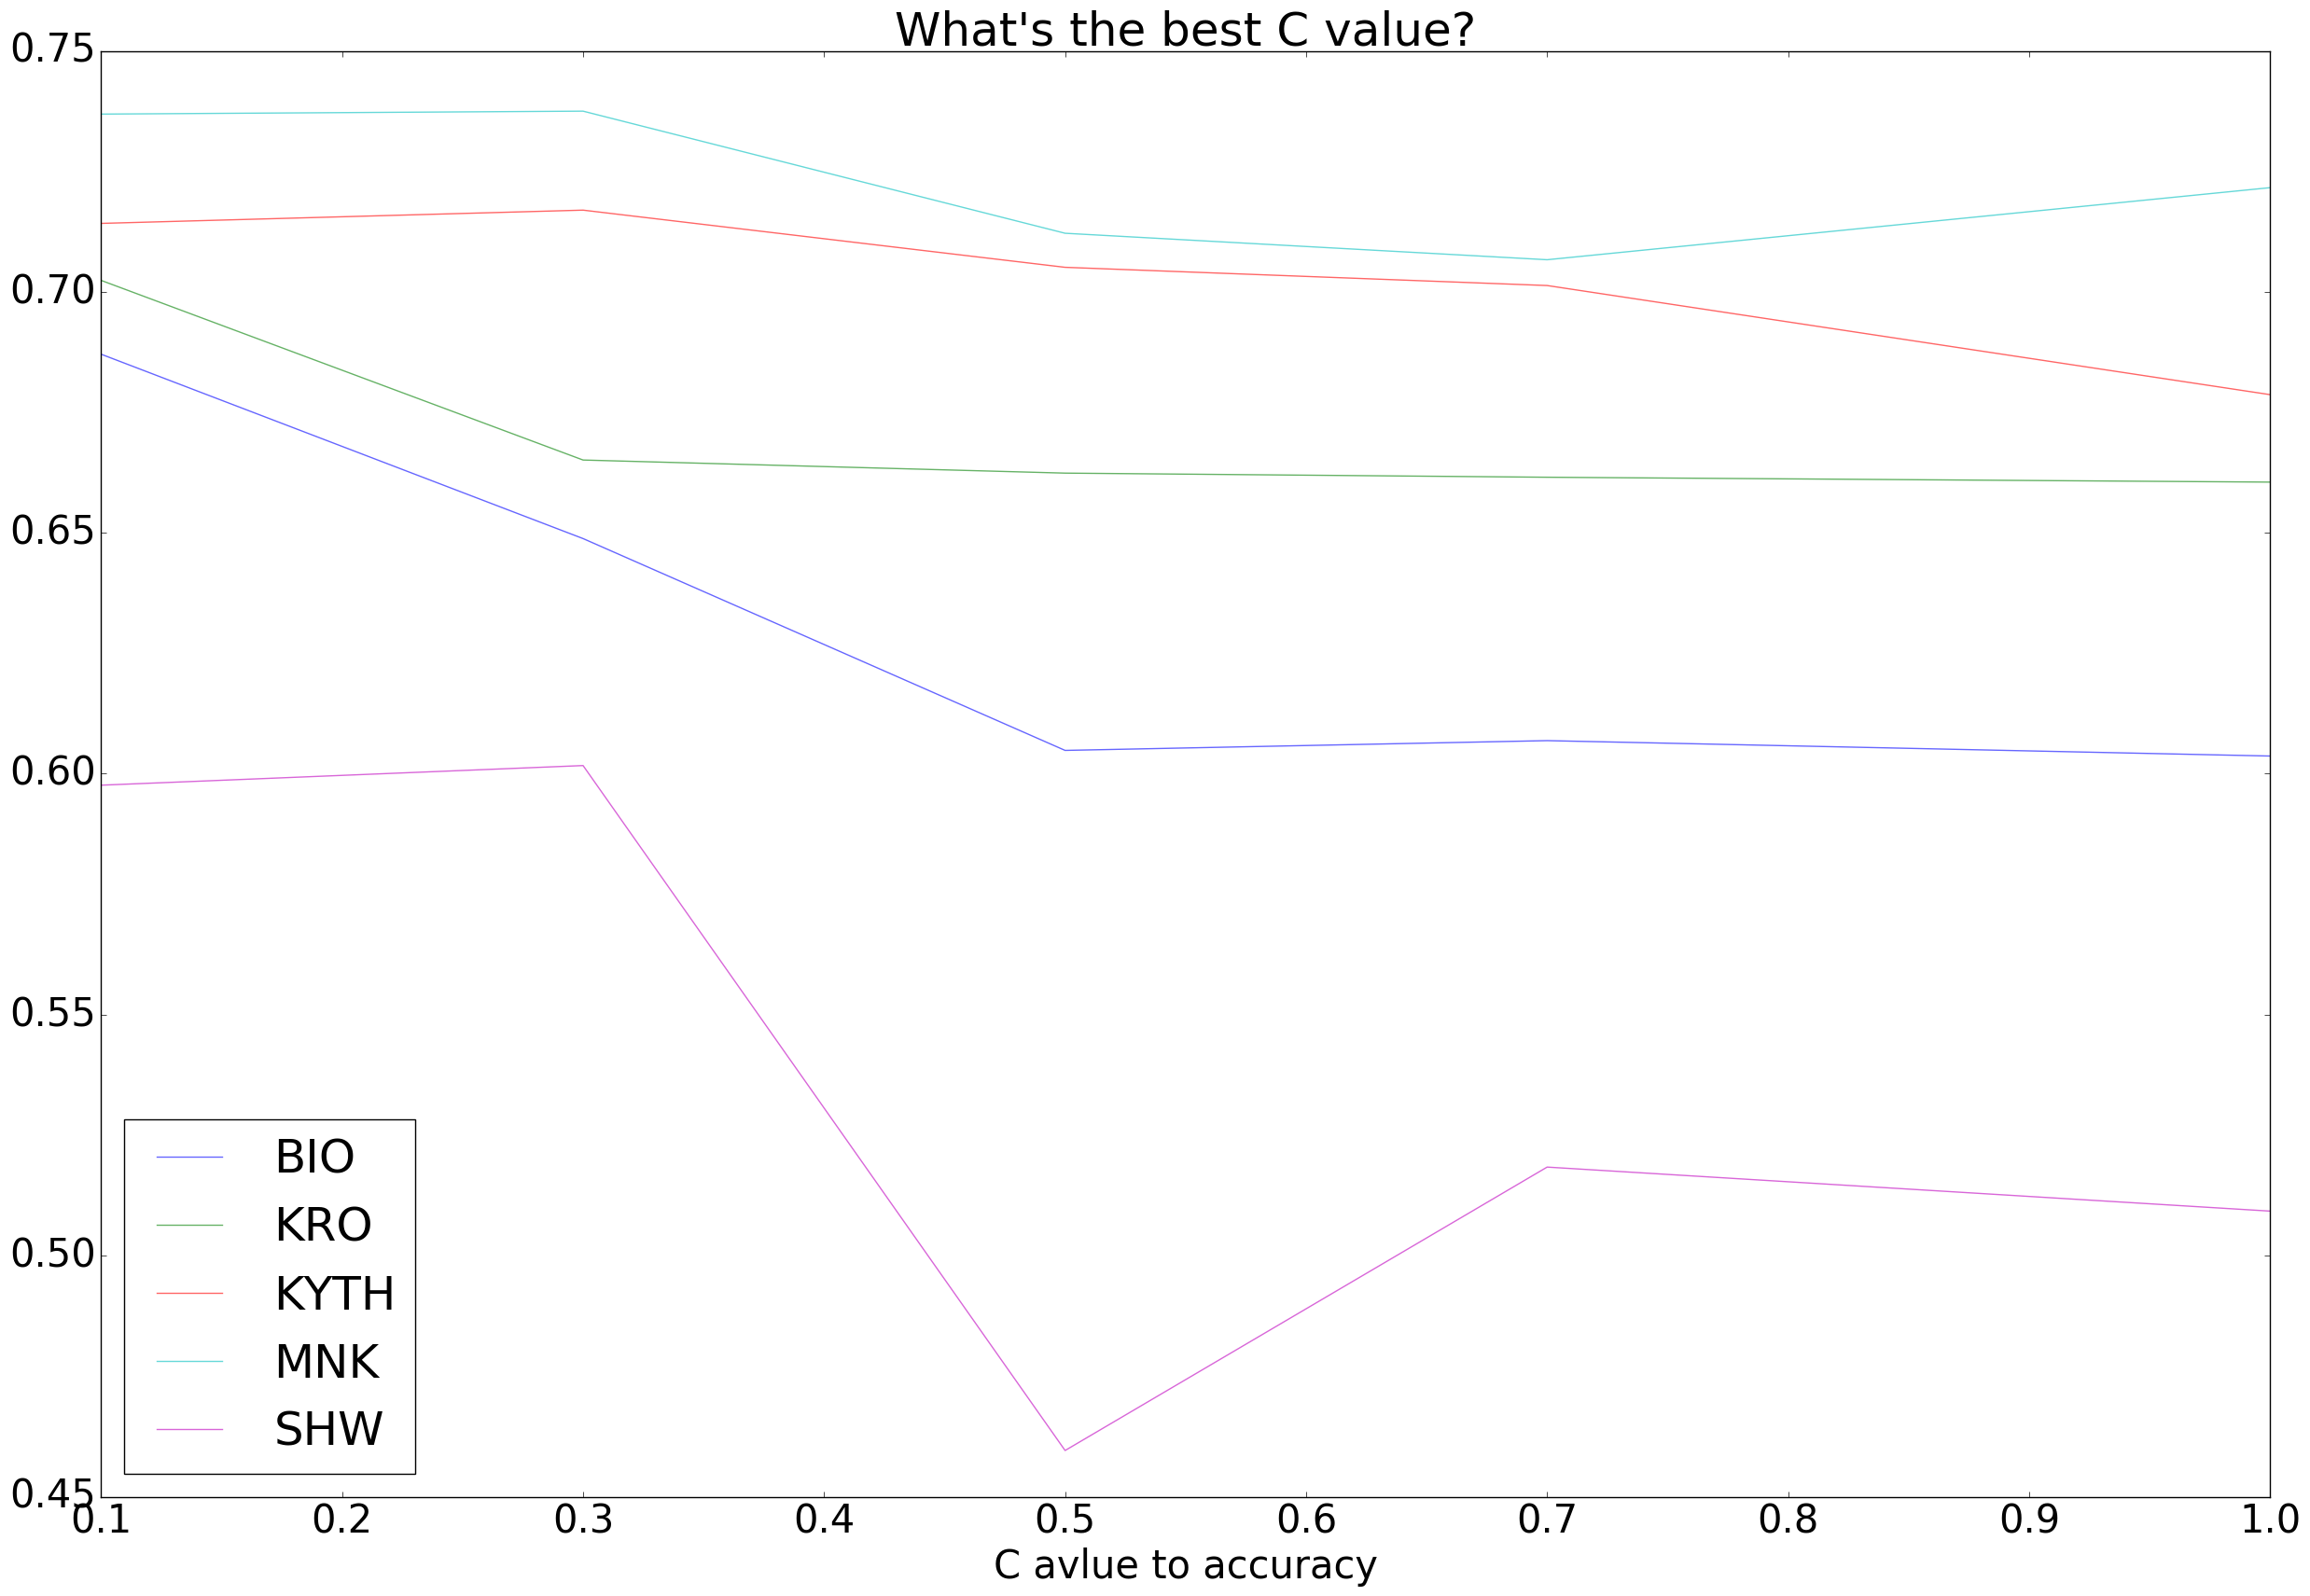

In [8]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

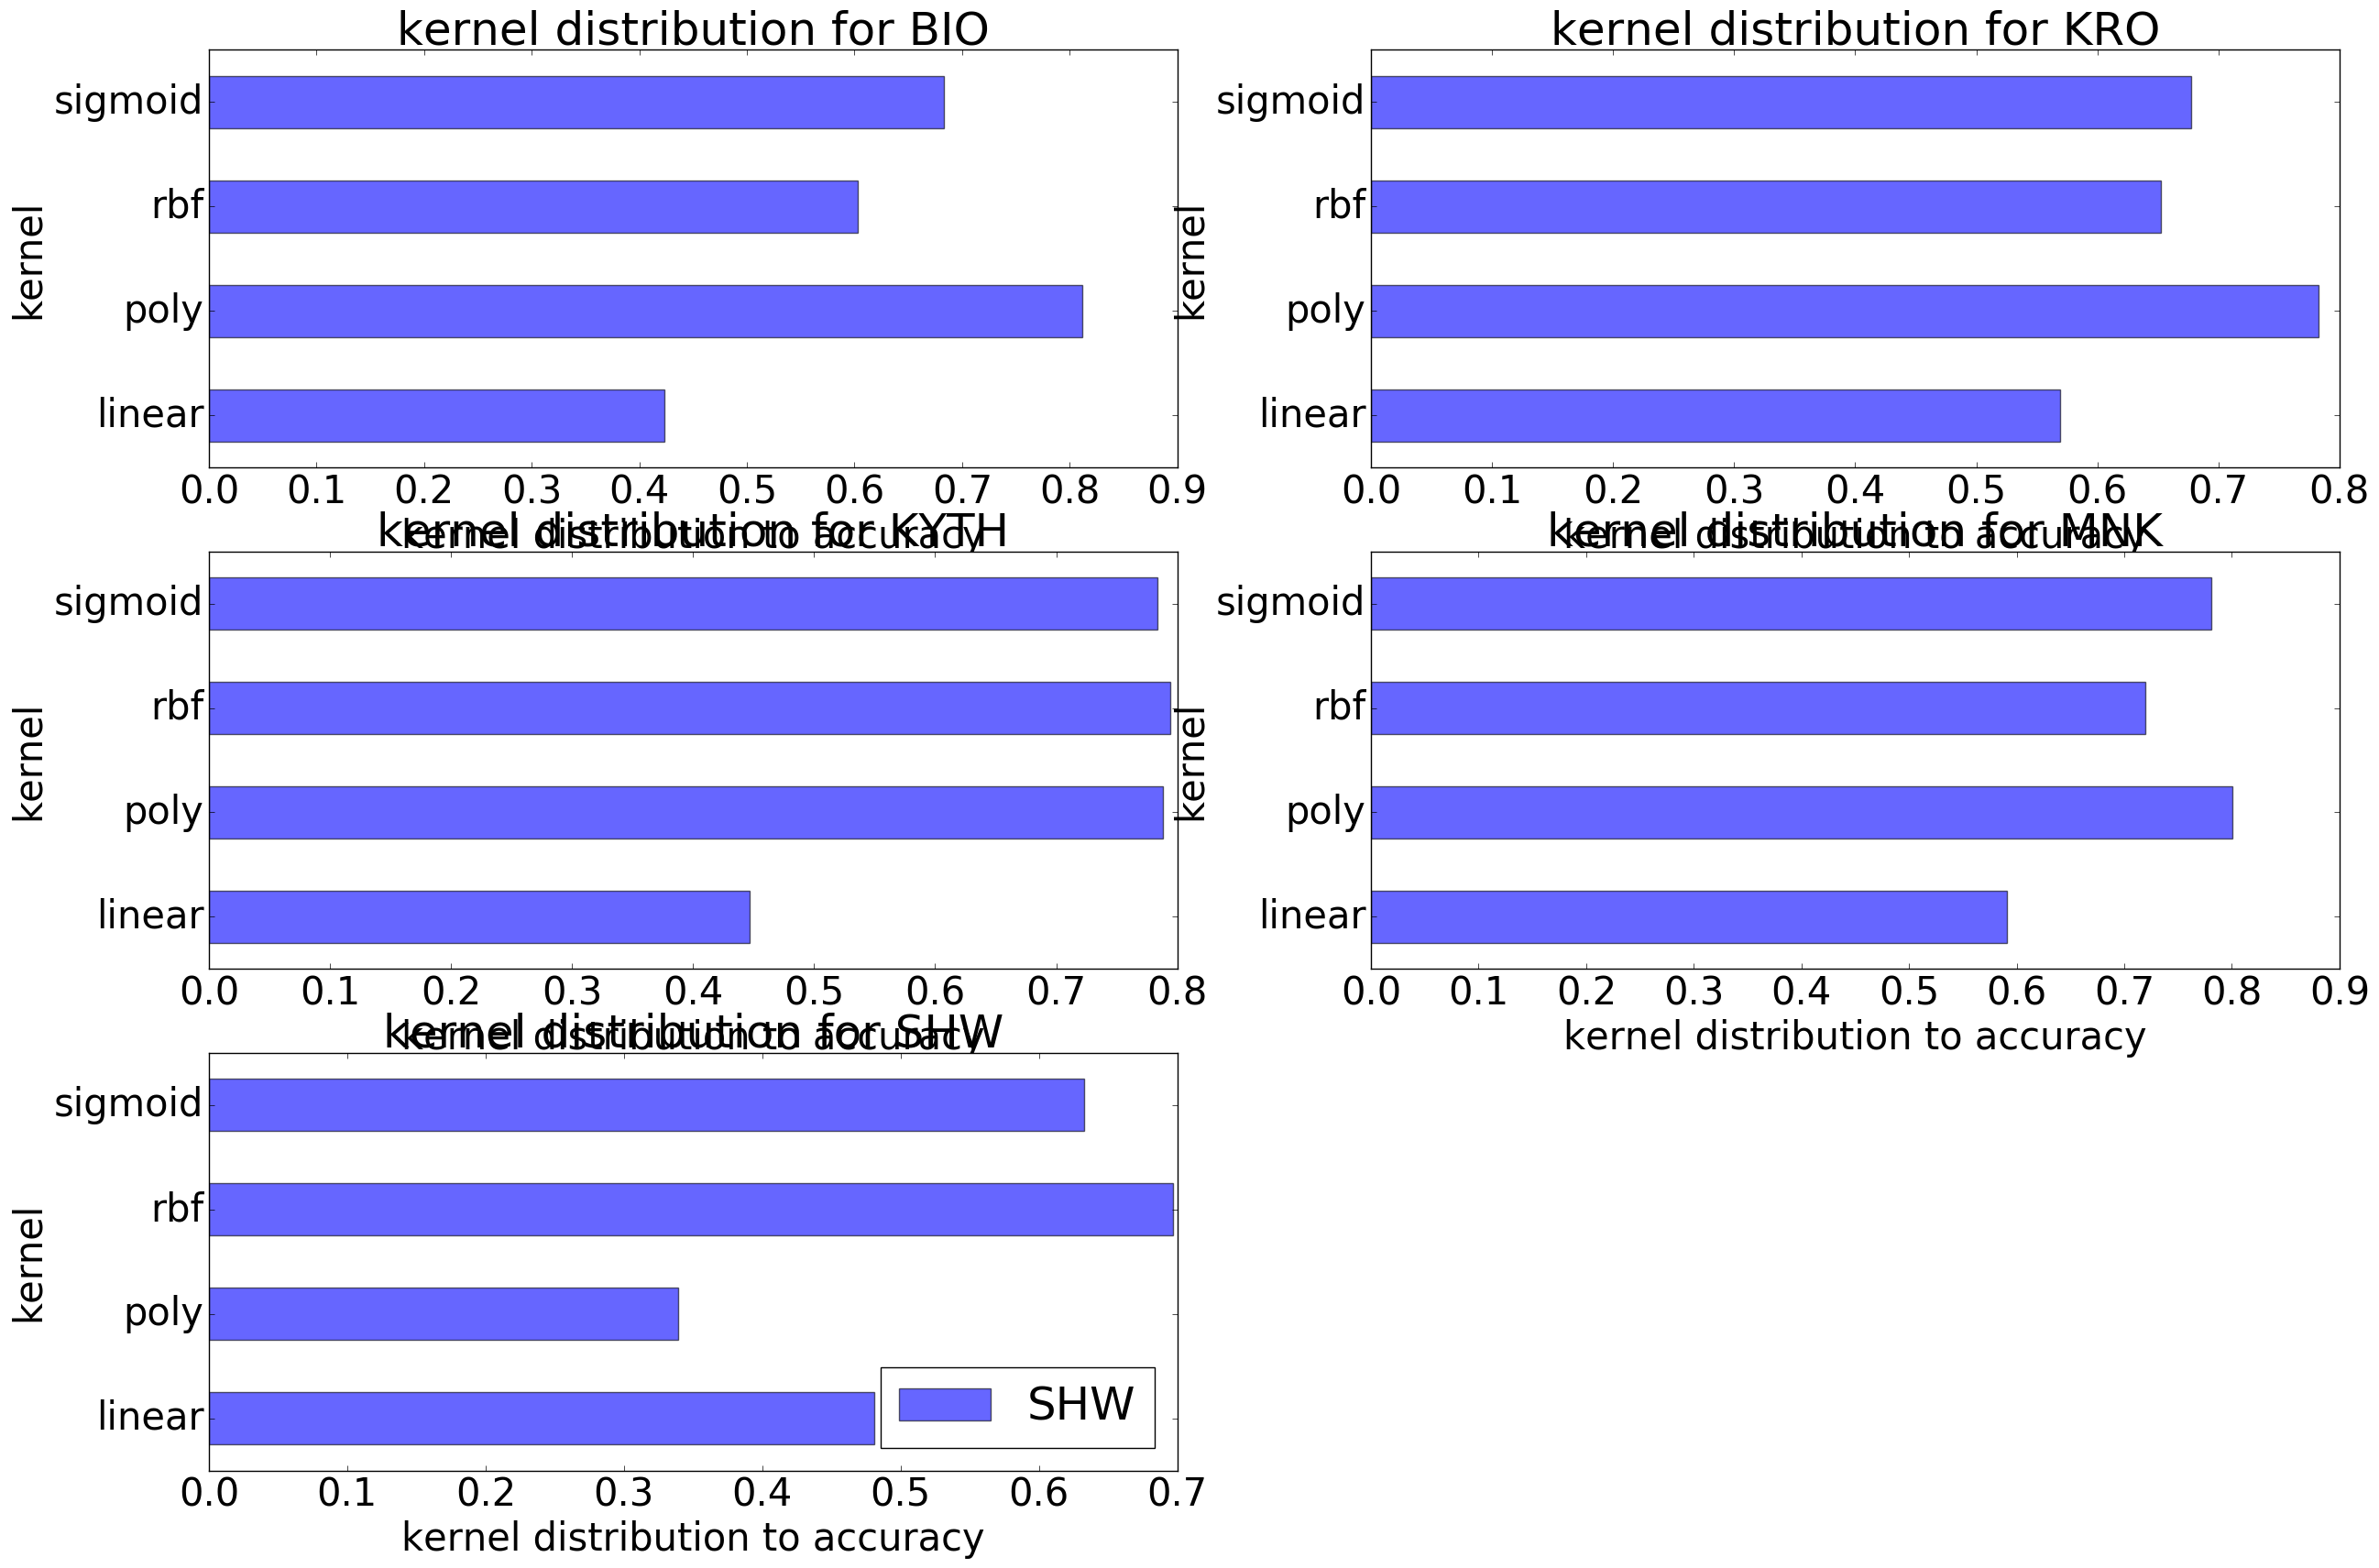

In [9]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(sresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('kernel').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('kernel distribution to accuracy')
    ax1.set_title("kernel distribution for {}".format(name))
plt.legend(loc='best')


The best average accuracy model is:

In [12]:
print(get_best_model(svm_models, saccuracies))
print(get_best_median_model(svm_models, saccuracies))

(3.9293460453925677, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=1200, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
(0.79805323105532311, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=1200, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


Which is mostly expected.
Also seems to be the best C value is not hit yet. The problem is that low C ignores mistakes. so we will check if we can have good classification with higher C and more iterations. We will try again with less parameters, medium C values and more iterations.
Let us check:

In [16]:
from sklearn.svm import SVC

# create iterables for all options and use itertools product
C=[0.8, 1.0 ,1.5]
max_iter=[1000, 1200, 1500, 2000]
kernel = ['rbf', 'sigmoid', 'poly']

s2models = [SVC(C=c, max_iter=mi, kernel=k) 
          for c, mi, k in product(C, max_iter, kernel)]

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s2accuracies = list(map(run_model, s2models))

In [18]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(s2models, s2accuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.max_iter, model.kernel, sn, acc))

s2results = DataFrame(data, columns=('C', 'max_iter', 'kernel', 'stock', 'accuracy'))

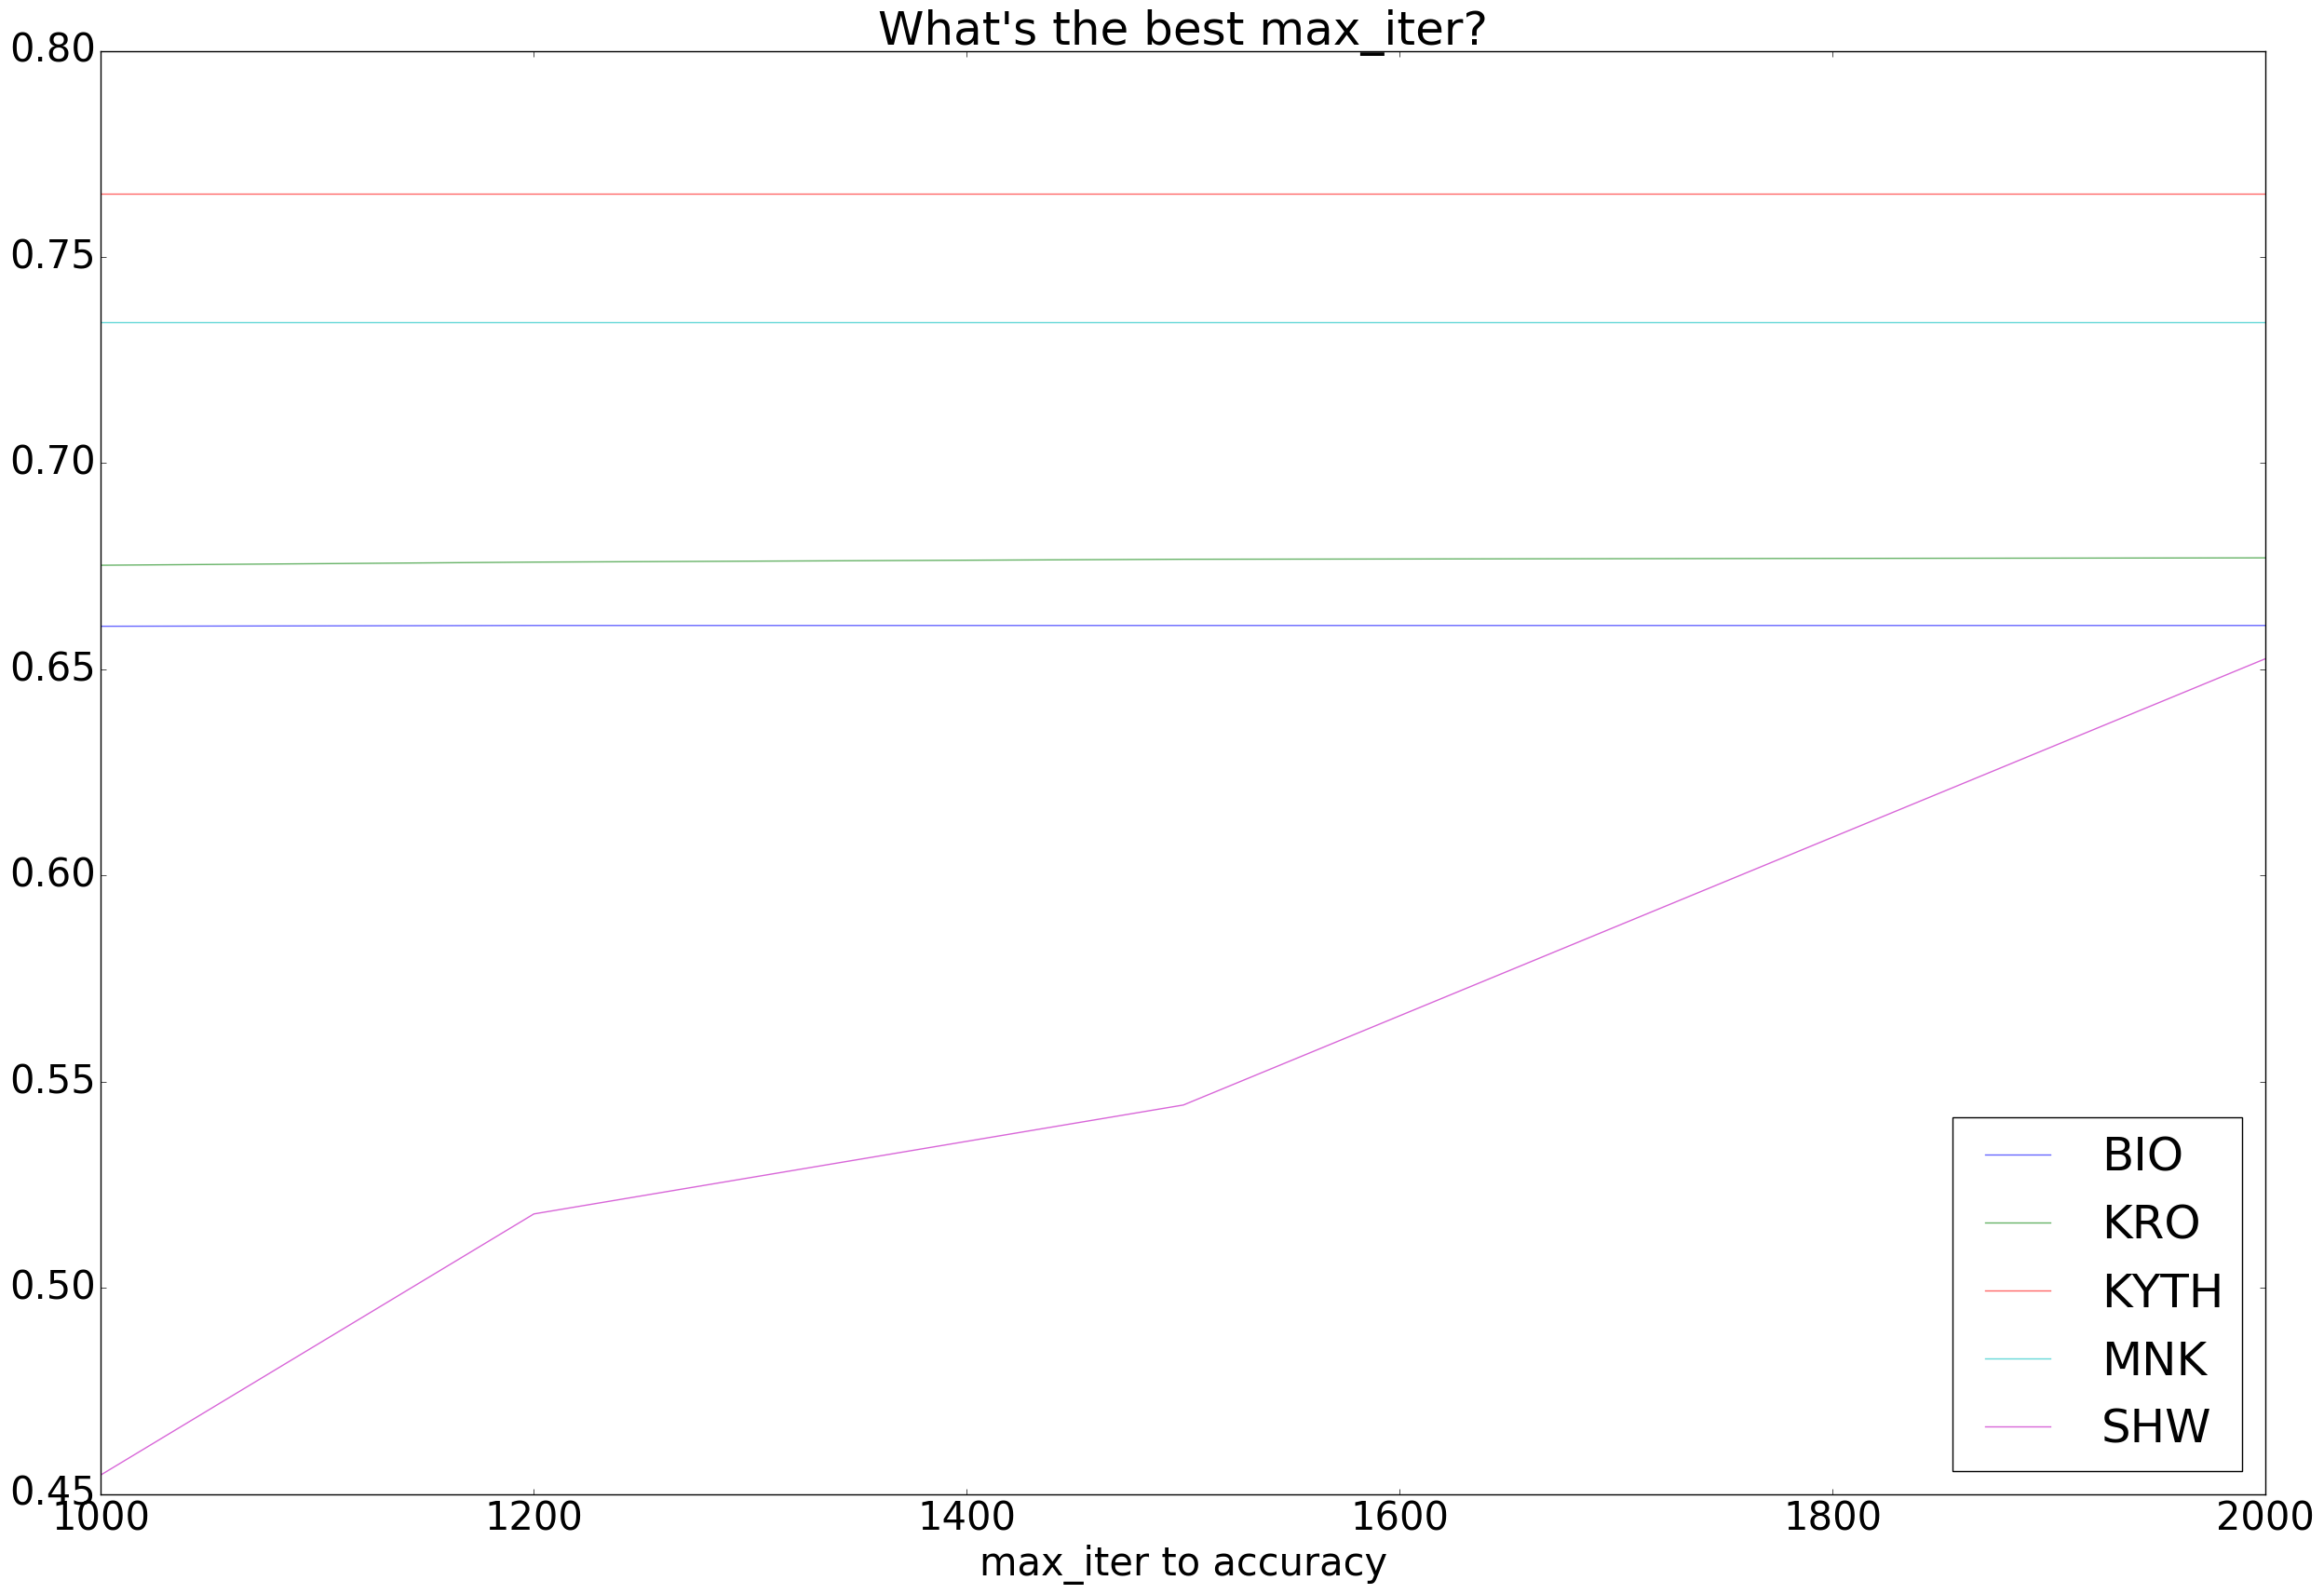

In [19]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in s2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max_iter to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_iter?" )

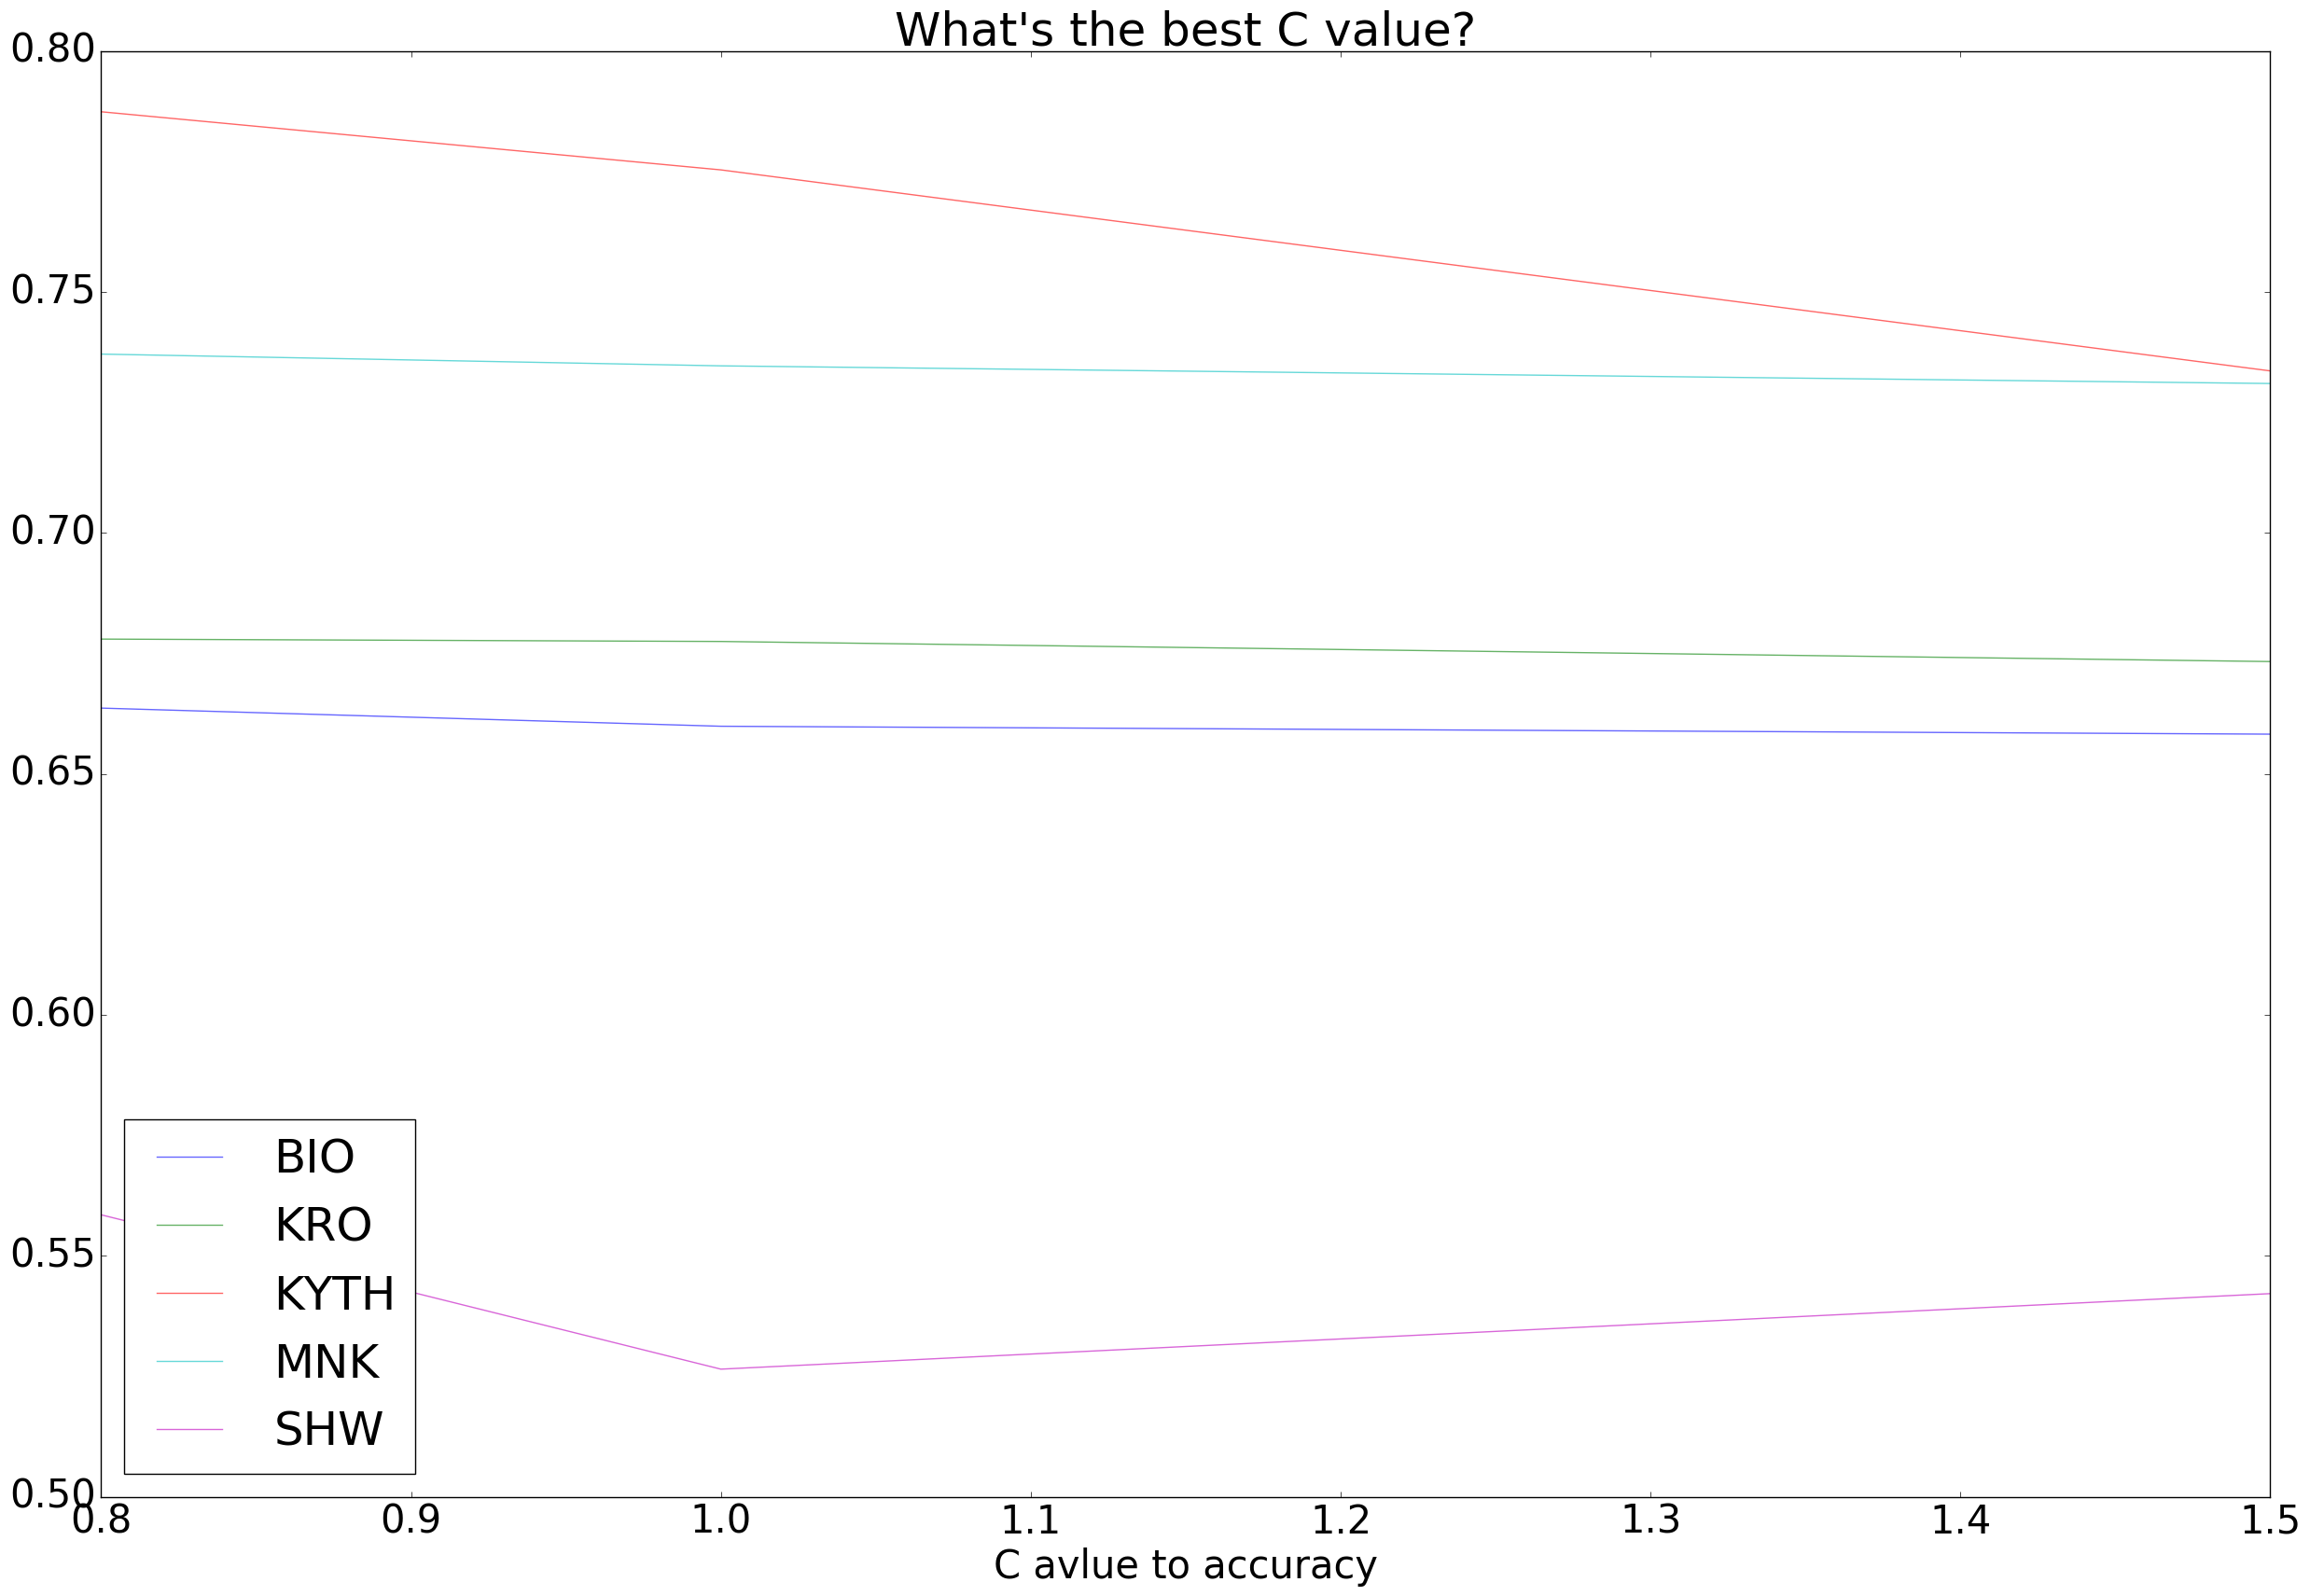

In [20]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in s2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

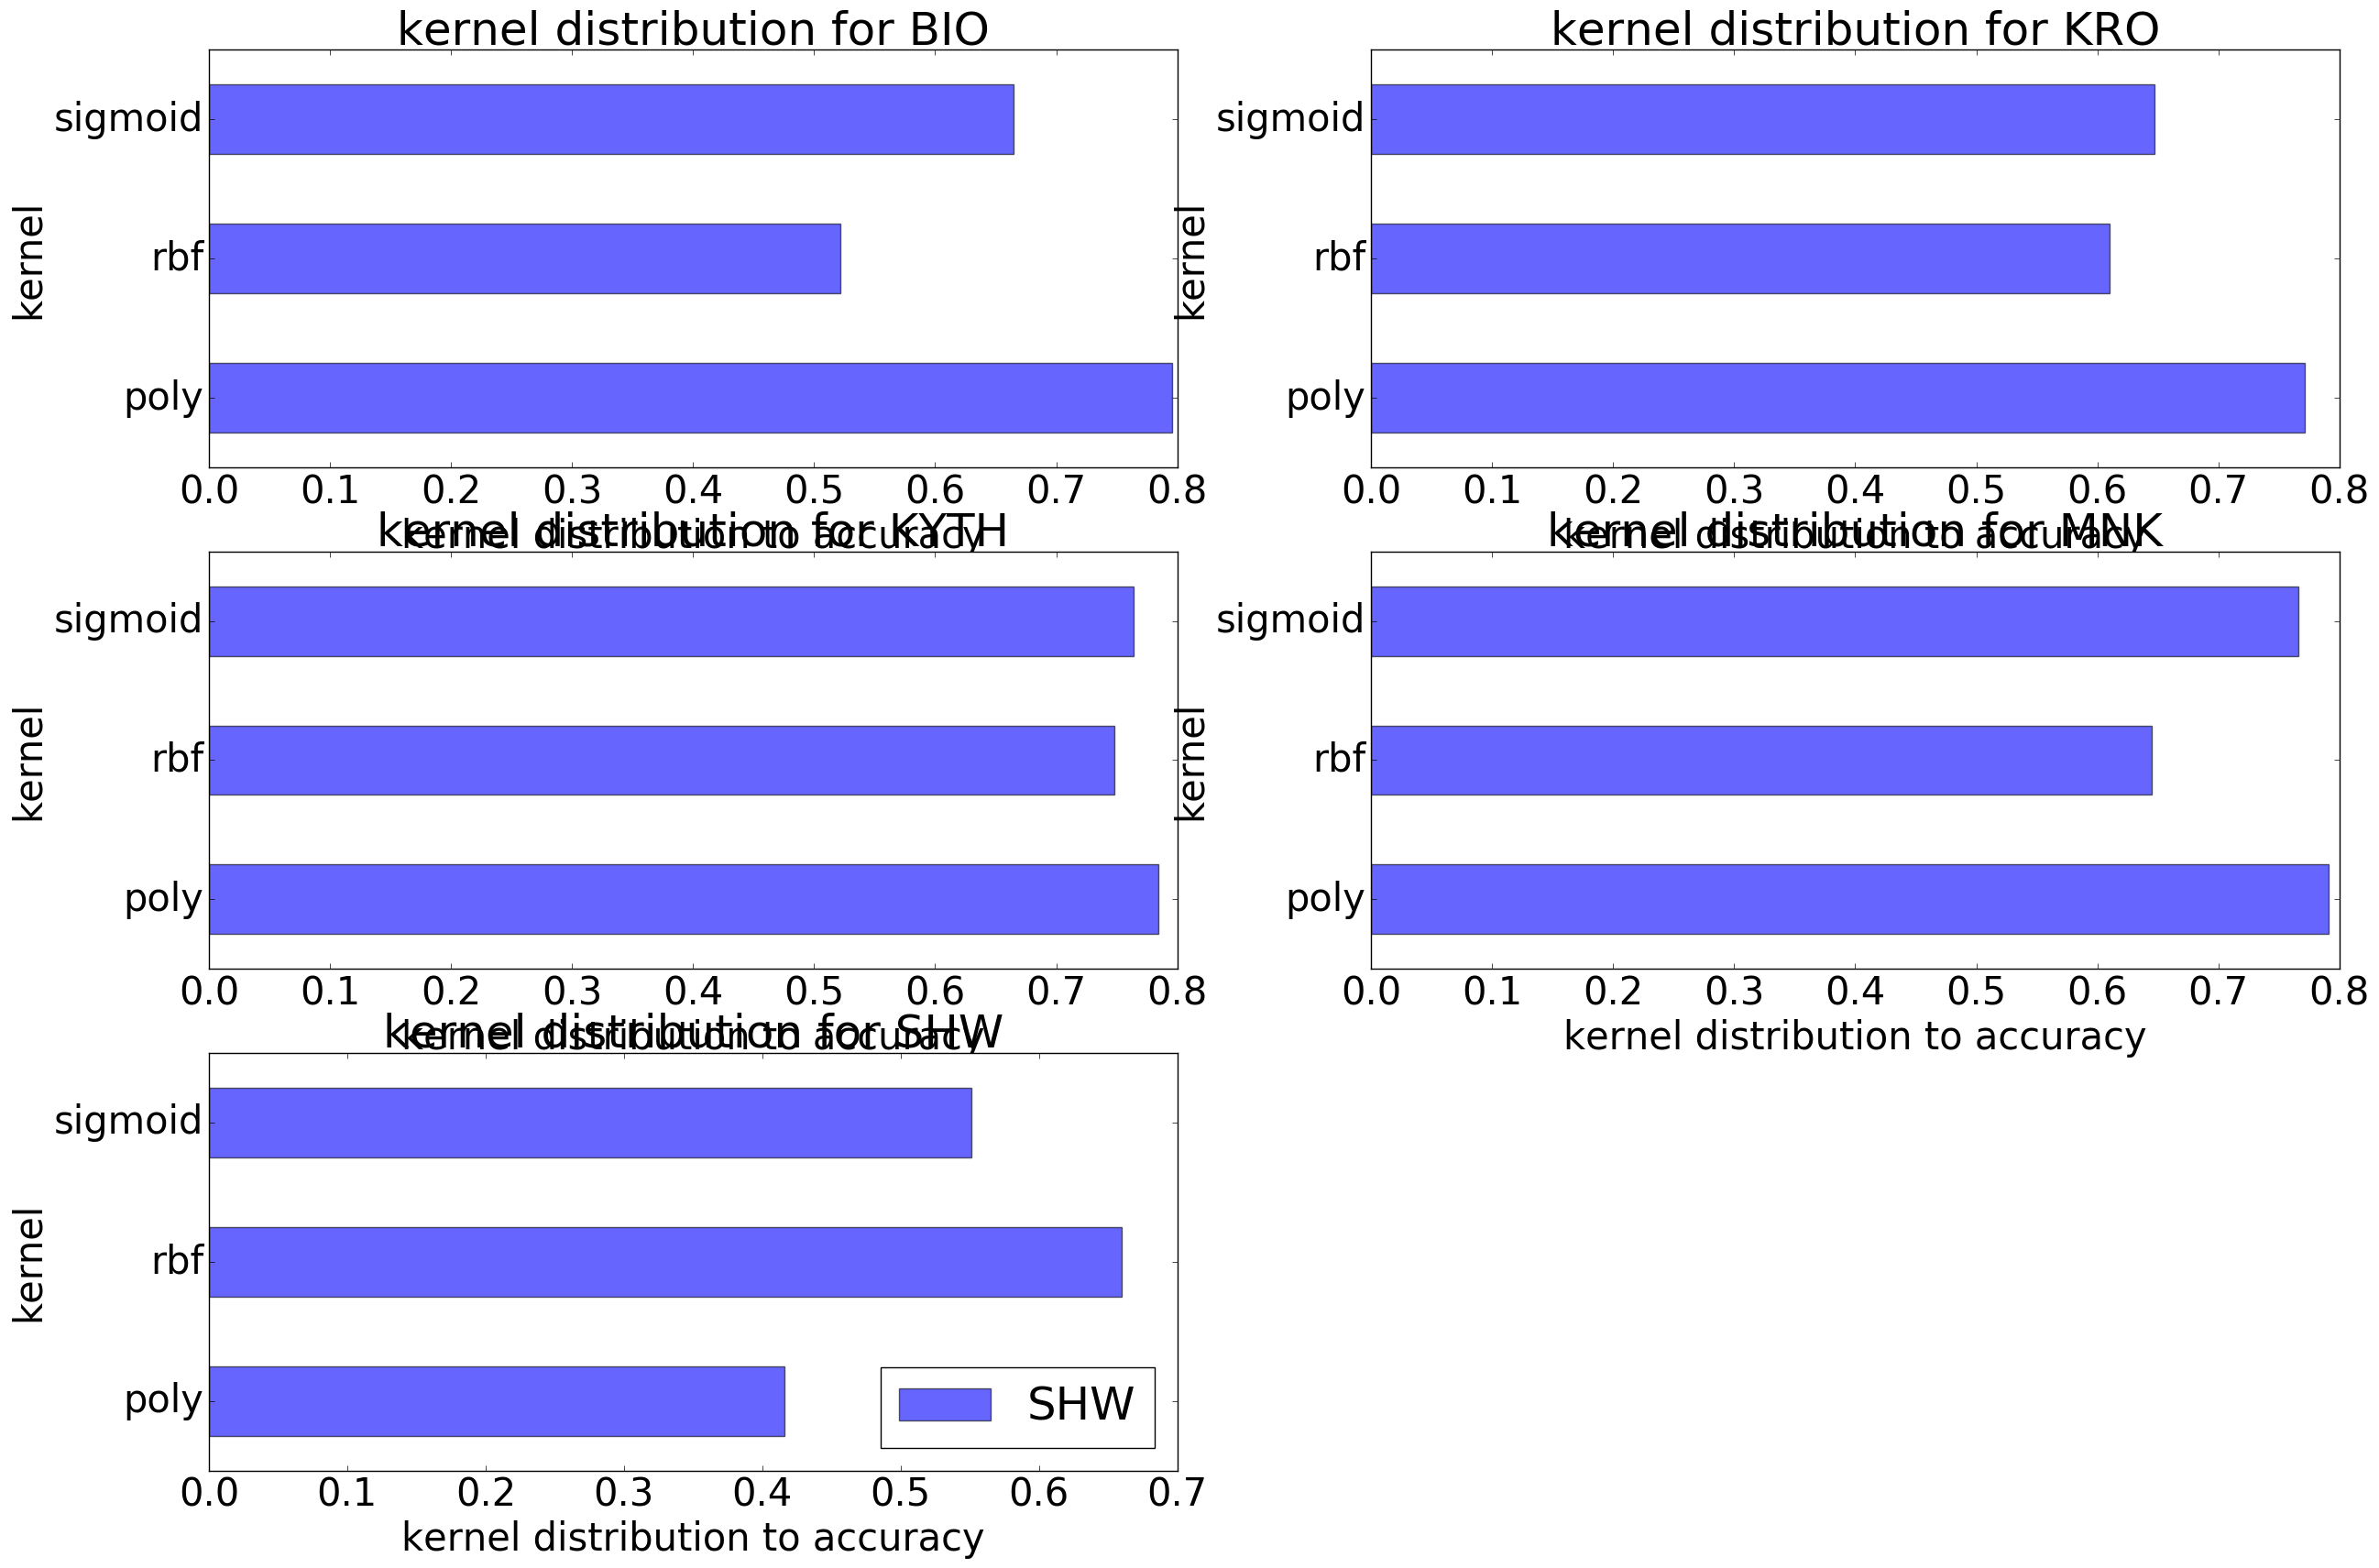

In [21]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(s2results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('kernel').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('kernel distribution to accuracy')
    ax1.set_title("kernel distribution for {}".format(name))
plt.legend(loc='best')


From checking it seems truly a lower C value should be chosen from what we decide to limit by.
We will need to choose for a C value and kernel=rbf and max_iter>=1200. This gives much better results then trees and we don't need to coerce our data to catagories. And it seems it really influences as the accuracy of BIO dropped really hard because we dont allow svm to be the default classifier


In [22]:
print(get_best_model(s2models, s2accuracies))
print(get_best_median_model(s2models, s2accuracies))

(3.9582618666376734, SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=2000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
(0.79609279609279604, SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=2000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


In [24]:
for i, m in enumerate(s2models):
    if m.kernel == 'poly' and m.C == 0.8 and m.max_iter == 2000:
        break
        
s2accuracies[i]

{'BIO': 0.80286530407023182,
 'KRO': 0.77607958565384882,
 'KYTH': 0.78688981868898189,
 'MNK': 0.79609279609279604,
 'SHW': 0.79633436213181519}

# Variance Reduction
We will try 3 approches. 

    1. using standard sklearn feature selection. 
    2. using QuarterClusterer try using data with less variance.
    3. using relation strength classifier.

In [8]:
accs = run_model(SVC())

In [12]:
print(sum(accs.values()))

3.31837933046


## Standard feature selection

We have plenty of samples so it seems wiser to use mutual_info score func, and trying to remove features by those who have small variance.

In [21]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

results = []
for i in range(1, 121, 10):
    filtered_stocks = [(SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(data, classes), classes) for data, classes in stocks]
    results.append((i, sum(run_model(SVC(), filtered_stocks).values())))
    
results.sort(key=lambda t: t[1])
for t in results[:10]:
    print('{} {}'.format(t[0],t[1]))


91 3.0634448035350665
61 3.1586194717387697
101 3.176654074155887
81 3.1962718226576254
71 3.24271699670898
111 3.2508271204143484
51 3.2584597323177857
31 3.2716746287175202
41 3.28643770325077
11 3.467894695790084


This gives us a small improvmant but not substantial enough.
Lets try a different approach:

In [25]:
from sklearn.feature_selection import VarianceThreshold

results2 = []
for i in range(1, 11):
    try:
        filtered_stocks = [(VarianceThreshold(threshold=float(i)/10).fit_transform(data, classes), classes) for data, classes in stocks]
        results2.append((i, sum(run_model(SVC(), filtered_stocks).values())))
    except Exception as e:
        print('Skipping threshold {} as it doesnt have enough variance: {}'.format(float(i)/100, str(e)))
    
results2.sort(key=lambda t: t[1])
for t in results2:
    print('{} {}'.format(t[0],t[1]))

10 3.1645401289917907
1 3.2175600969463507
2 3.2175600969463507
3 3.2175600969463507
4 3.2175600969463507
5 3.2175600969463507
6 3.2175600969463507
7 3.2175600969463507
8 3.2175600969463507
9 3.2175600969463507


## Quarter Classifier

In [28]:
from Classifiers import classifiers

quarterizer = classifiers.Quarterizer().fit(stocks[0][0])
quarters = pandas.concat([quarterizer.transform(d) for d,c in stocks])
quarters.describe()

,0,1,2,3,4,5,6,7,8,9,...,712,713,714,715,716,717,718,719,720,721
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,...,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,-1.166515,-1.160028,-1.153850,-1.148183,-1.143229,-1.139189,-1.136266,-1.134661,-1.134576,-1.136045,...,-0.567933,-0.445574,-0.327797,-0.220037,-0.127017,-0.053462,-0.003060,0.024629,0.031082,0.017774
std,2.697344,2.695870,2.716602,2.741835,2.762661,2.775970,2.781992,2.782545,2.779904,2.776307,...,5.862200,6.001641,6.110431,6.228944,6.367522,6.496243,6.565312,6.536801,6.374755,6.042730
min,-7.180453,-7.081043,-7.237665,-7.883670,-8.237539,-8.337366,-8.221242,-7.927261,-7.493517,-6.958100,...,-9.693521,-10.968565,-11.948655,-12.537482,-12.638734,-12.156099,-10.993268,-9.053928,-7.736395,-7.671360
25%,-2.843656,-2.843992,-2.843055,-2.845738,-2.848458,-2.850582,-2.862501,-2.848320,-2.840663,-2.848786,...,-2.970533,-2.955282,-2.956861,-2.901402,-2.911704,-2.887583,-2.875127,-2.870263,-2.870554,-2.831041
50%,-2.584973,-2.600785,-2.614316,-2.584422,-2.599009,-2.597153,-2.593953,-2.591194,-2.599746,-2.604249,...,-2.215353,-2.221403,-2.063798,-2.052390,-2.011536,-2.112609,-2.189342,-2.065904,-2.038702,-1.972767
75%,1.946519,2.002208,1.961620,1.913106,1.929182,1.987506,2.048697,2.045505,2.088920,2.119520,...,0.739899,0.742141,1.090213,1.352441,1.172843,1.389354,1.539184,1.424363,1.433567,1.233152
max,4.602059,4.935822,5.230256,5.508054,5.794210,6.021569,6.191266,6.304439,6.362222,6.368024,...,69.139259,68.043155,64.494012,58.977252,51.978296,48.640885,52.352624,54.136662,53.559761,50.188682


In [45]:
from sklearn.cluster import KMeans

clusters = 6
q_clf = KMeans(n_clusters=clusters).fit(quarters.drop(['start', 'end'], axis=1))

In [58]:
import collections
import pandas as pd

def cut_by_classes(original_data, q_data, classes):
    """
    :param original_data: Data from which quarters were made
    :param q_data: Data after transform
    :param classes: the classes for q_data
    :return: dictionary of class to dataframe made from original data
    """
    if not isinstance(classes, pandas.Series):
        classes = pandas.Series(classes)

    res = collections.defaultdict(lambda: pd.DataFrame())
    for q_row, c_row in zip(q_data.iterrows(), classes.iteritems()):
        q_row = q_row[1]
        c_row = c_row[1]
        res[c_row] = pd.concat([res[c_row], original_data.loc[q_row['start']:q_row['end']]])

    return res

In [80]:
q_data = [quarterizer.transform(d) for d, c in stocks]
c_stocks = [(d, q_clf.predict(d.drop(['start', 'end'], axis=1))) for d in q_data]

combined = []
for d, c in stocks:
    d2 = d.copy(False)
    d2['class'] = c
    combined.append(d2)
by_classes = [cut_by_classes(d, qs,  qcs) for d, (qs, qcs) in zip(combined, c_stocks)]

In [116]:
def run_clustered_model(model, class_dict=by_classes):
    scores = {}
    for sn, d_dict in zip(stock_names, class_dict):
        scores[sn] = 0
        for c in d_dict.keys():
            data, classes = d_dict[c].drop('class', axis=1), d_dict[c]['class']
            if classes.isnull().sum() > 0:
                classes = classes.fillna(classes.median())
            if len(classes.unique()) == 1:
                scores[sn] += 0.8
            else:
                classes = list(classes)
                try:
                    scores[sn] += sum(cross_val_score(model, data, classes))/3
                except Exception as e:
                    print(sn, c)
                    print(classes)
                    print(str(e))
        scores[sn] /= len(d_dict)
    return scores

In [117]:
s_cluster_accuracies = run_clustered_model(SVC())

In [118]:
print(get_best_model([SVC()], [s_cluster_accuracies]))
print(get_best_median_model([SVC()], [s_cluster_accuracies]))

(4.2628851084926493, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
(0.84653088204461002, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


## Strength Classifier using relationship strengths

In [5]:
from Utilities.clustering import StrengthCalc

sc = StrengthCalc()

In [6]:
from Classifiers.classifiers import ConnectionStrengthClassifier

# dictionary of market name to strength
stock_strengths = [sc.get_strength_stock(sn, 5, 325, 2, 0.1) for sn in stock_names]

clf = ConnectionStrengthClassifier()

In [7]:
from Utilities import clean_market_name

cols = []
for d, c in stocks:
    cols.extend(d.columns)
all_cols = set(cols)

strengths = []
connections_cols = []
for i, sn in enumerate(stock_names):
    cur_cols = []
    cur_strengths = []
    for m in ld.get_market_names():
        cur_cols.append(list(filter(lambda c: clean_market_name(m) in c, all_cols)))
        cur_strengths.append(stock_strengths[i][m])
    connections_cols.append(cur_cols)
    strengths.append(cur_strengths)

In [8]:
def run_strength_model(model, stocks=stocks, strength=strengths, cols=connections_cols):
    scores = {sn: [] for sn in stock_names}
    for sn, (data, classes), st, cs in zip(stock_names, stocks, strength, cols):
        fit_params = {'connection_columns': cs, 'strengths': st}
        scores[sn] = (sum(cross_val_score(model, data, classes, fit_params=fit_params))/3) 
    return scores

In [25]:
import Classifiers.classifiers

model = Classifiers.classifiers.ConnectionStrengthClassifier(base_estimator=SVC(probability=True))
st_accuracies = run_strength_model(model)

In [26]:
print(sum(st_accuracies.values()))

4.04578955284


 ## Find best SVM
 We take the forth best svms that we found and add to them two other svms (six in total).
 We "feed" them to the best strength classifer to find the best one.

In [12]:
import Classifiers.classifiers
from sklearn.svm import SVC

C=[0.1, 0.3, 0.5, 0.7, 1.0]

bsvm_model = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.001, base_strength=0.1, combined_weight=0, 
              base_estimator=SVC(C=c, probability=True)) for c in C]

true_scores = []
false_scores = []


train_data = [(d.iloc[0:round(len(d)*0.7)], c.iloc[0:round(len(d)*0.7)]) for d, c in stocks]
test_data = [(d.iloc[round(len(d)*0.7):len(d)-1], c.iloc[round(len(d)*0.7):len(d)-1]) for d, c in stocks]
trues = [(d.loc[c.index[c == True]], c.loc[c.index[c == True]]) for d, c in test_data]
falses = [(d.loc[c.index[c == False]], c.loc[c.index[c == False]]) for d, c in test_data]

for m in bsvm_model:
    true_scores.append([])
    false_scores.append([])
    for (d, c), st, cs, (td, tc), (fd, fc) in zip(train_data, strengths, connections_cols, trues, falses):
        m.fit(d, c, cs, st)
        tc[0]= False
        fc[0]= True
        true_scores[-1].append(m.score(td, tc))
        false_scores[-1].append(m.score(fd.fillna(0), fc))

In [14]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [15]:
for t,f,m in zip(true_scores, false_scores, bsvm_model):
    print("model: "+str(m)+" score: "+str(100*(mean(f)*0.8+mean(t)*0.2))+" True positive: "+str(mean(t))+" False positive: "+str(mean(f)))

model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0, threshold=0.001) score: 80.08666079121575 True positive: 0.015626922805946315 False positive: 0.9971765291887102
model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0, threshold=0.001) score: 80.08666079121575 True positive: 0.015626922805946315 False positive: 0.9971765291887102
model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision

In [17]:
import Classifiers.classifiers
from sklearn.svm import SVC

C=[2.0, 5.0, 10.0]

bsvm_model2 = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.001, base_strength=0.1, combined_weight=0, 
              base_estimator=SVC(C=c, probability=True,max_iter=1200)) for c in C]

true_scores = []
false_scores = []


train_data = [(d.iloc[0:round(len(d)*0.7)], c.iloc[0:round(len(d)*0.7)]) for d, c in stocks]
test_data = [(d.iloc[round(len(d)*0.7):len(d)-1], c.iloc[round(len(d)*0.7):len(d)-1]) for d, c in stocks]
trues = [(d.loc[c.index[c == True]], c.loc[c.index[c == True]]) for d, c in test_data]
falses = [(d.loc[c.index[c == False]], c.loc[c.index[c == False]]) for d, c in test_data]

for m in bsvm_model2:
    true_scores.append([])
    false_scores.append([])
    for (d, c), st, cs, (td, tc), (fd, fc) in zip(train_data, strengths, connections_cols, trues, falses):
        m.fit(d, c, cs, st)
        tc[0]= False
        fc[0]= True
        true_scores[-1].append(m.score(td, tc))
        false_scores[-1].append(m.score(fd.fillna(0), fc))

C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packag

In [24]:
for t,f,m in zip(true_scores, false_scores, bsvm_model2):
    print("model: "+str(m)+" score: "+str(100*(mean(f)*0.8+mean(t)*0.2))+" True positive: "+str(mean(t))+" False positive: "+str(mean(f)))

model: ConnectionStrengthClassifier(base_estimator=SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=1200, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0, threshold=0.001) score: 80.08666079121575 True positive: 0.015626922805946315 False positive: 0.9971765291887102
model: ConnectionStrengthClassifier(base_estimator=SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=1200, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0, threshold=0.001) score: 80.1438036483586 True positive: 0.01848406566308917 False positive: 0.9971765291887102
model: ConnectionStrengthClassifier(base_estimator=SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decis

In case increasing C won't help we check what increasing base_strength will do

In [21]:
import Classifiers.classifiers
from sklearn.svm import SVC

C=[0.5]
base_strength = [0.1,0.2,0.4,0.6,1.0]

bsvm_model3 = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.001, base_strength=bs, combined_weight=0, 
              base_estimator=SVC(C=0.5, probability=True,max_iter=500)) for bs in base_strength]

true_scores3 = []
false_scores3 = []


train_data3 = [(d.iloc[0:round(len(d)*0.7)], c.iloc[0:round(len(d)*0.7)]) for d, c in stocks]
test_data3 = [(d.iloc[round(len(d)*0.7):len(d)-1], c.iloc[round(len(d)*0.7):len(d)-1]) for d, c in stocks]
trues3 = [(d.loc[c.index[c == True]], c.loc[c.index[c == True]]) for d, c in test_data]
falses3 = [(d.loc[c.index[c == False]], c.loc[c.index[c == False]]) for d, c in test_data]

for m in bsvm_model3:
    true_scores3.append([])
    false_scores3.append([])
    for (d, c), st, cs, (td, tc), (fd, fc) in zip(train_data3, strengths, connections_cols, trues3, falses3):
        m.fit(d, c, cs, st)
        tc[0]= False
        fc[0]= True
        true_scores3[-1].append(m.score(td, tc))
        false_scores3[-1].append(m.score(fd.fillna(0), fc))

C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\s

In [20]:
for t,f,m in zip(true_scores3, false_scores3, bsvm_model3):
    print("model: "+str(m)+" score: "+str(100*(mean(f)*0.8+mean(t)*0.2))+" True positive: "+str(mean(t))+" False positive: "+str(mean(f)))

model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0, threshold=0.001) score: 80.29878200333695 True positive: 0.026232983412006923 False positive: 0.9971765291887102
model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0, threshold=0.001) score: 80.08666079121575 True positive: 0.015626922805946315 False positive: 0.9971765291887102
model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decisi

Here we check a change over combined_weight

In [22]:
import Classifiers.classifiers
from sklearn.svm import SVC

C=[0.5]
combined_weights = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

bsvm_model4 = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.001, base_strength=0.1, combined_weight=cw, 
              base_estimator=SVC(C=0.5, probability=True,max_iter=500)) for cw in combined_weights]

true_scores4 = []
false_scores4 = []


train_data4 = [(d.iloc[0:round(len(d)*0.7)], c.iloc[0:round(len(d)*0.7)]) for d, c in stocks]
test_data4 = [(d.iloc[round(len(d)*0.7):len(d)-1], c.iloc[round(len(d)*0.7):len(d)-1]) for d, c in stocks]
trues4 = [(d.loc[c.index[c == True]], c.loc[c.index[c == True]]) for d, c in test_data]
falses4 = [(d.loc[c.index[c == False]], c.loc[c.index[c == False]]) for d, c in test_data]

for m in bsvm_model4:
    true_scores4.append([])
    false_scores4.append([])
    for (d, c), st, cs, (td, tc), (fd, fc) in zip(train_data4, strengths, connections_cols, trues4, falses4):
        m.fit(d, c, cs, st)
        tc[0]= False
        fc[0]= True
        true_scores4[-1].append(m.score(td, tc))
        false_scores4[-1].append(m.score(fd.fillna(0), fc))

C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\s

In [23]:
for t,f,m in zip(true_scores4, false_scores4, bsvm_model4):
    print("model: "+str(m)+" score: "+str(100*(mean(f)*0.8+mean(t)*0.2))+" True positive: "+str(mean(t))+" False positive: "+str(mean(f)))

model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0, threshold=0.001) score: 81.02092540615263 True positive: 0.06714207432109782 False positive: 0.9959760489966334
model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=500, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
               base_strength=0.1, combined_weight=0.2, threshold=0.001) score: 80.25808936264431 True positive: 0.02419835137737488 False positive: 0.9971765291887102
model: ConnectionStrengthClassifier(base_estimator=SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decisi

In [29]:
import Utilities.confusion_matrix

In [30]:
cm = Utilities.confusion_matrix.ConfusionMatrix(stocks)

In [32]:
print(cm)

TypeError: __str__ returned non-string (type generator)

In [33]:
cm.calc_mat(bsvm_model4,strengths, connections_cols)

C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\sdshw\Anaconda3\lib\site-packages\s

ValueError: Found input variables with inconsistent numbers of samples: [395, 1961]